In [2]:
# Import all necessary python libraries/pacakges
import re
#import tweepy
#from tweepy.streaming import StreamListener
#from tweepy import OAuthHandler
#from tweepy import Stream
from textblob import TextBlob
import csv 
import pandas as pd
import json
import datetime as dt

import os,sys
import time


In [3]:
def load_api():
    # Function that loads the twitter API after authorizing the user

    access_token = "1058460791xxxxxxxxxxxxxxx"
    access_token_secret = "1058460791xxxxxxxxxxxxxxx"
    consumer_key = "1058460791xxxxxxxxxxxxxxx"
    consumer_secret = "1058460791xxxxxxxxxxxxxxx"

    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    # load the twitter API via tweepy
    return tweepy.API(auth)


In [4]:
def tweet_search(api, query, max_tweets, max_id, since_id, geocode):
    #  Function that takes in a search string 'query', the maximum
    #  number of tweets 'max_tweets', and the minimum (i.e., starting)
    #  tweet id. It returns a list of tweepy.models.Status objects. '''

    searched_tweets = []
    while len(searched_tweets) < max_tweets:
        remaining_tweets = max_tweets - len(searched_tweets)
        try:
            new_tweets = api.search(q=query, count=remaining_tweets, since_id=str(since_id), max_id=str(max_id-1))
#                                   geocode=geocode)
            print('found',len(new_tweets),'tweets')
            if not new_tweets:
                print('no tweets found')
                break
            searched_tweets.extend(new_tweets)
            max_id = new_tweets[-1].id
        except tweepy.TweepError:
            print('exception raised, waiting 15 minutes')
            print('(until:', dt.datetime.now()+dt.timedelta(minutes=15), ')')
            time.sleep(15*60)
            break # stop the loop
    return searched_tweets, max_id

In [5]:
def get_tweet_id(api, date='', days_ago=9, query='a'):
     #   Function that gets the ID of a tweet. This ID can then be
     #   used as a 'starting point' from which to search. The query is
     #   required and has been set to a commonly used word by default.
     #   The variable 'days_ago' has been initialized to the maximum
     #   amount we are able to search back in time (9)

    if date:
        # return an ID from the start of the given day
        td = date + dt.timedelta(days=1)
        tweet_date = '{0}-{1:0>2}-{2:0>2}'.format(td.year, td.month, td.day)
        tweet = api.search(q=query, count=1, until=tweet_date)
    else:
        # return an ID from __ days ago
        td = dt.datetime.now() - dt.timedelta(days=days_ago)
        tweet_date = '{0}-{1:0>2}-{2:0>2}'.format(td.year, td.month, td.day)
        # get list of up to 10 tweets
        tweet = api.search(q=query, count=10, until=tweet_date)
        print('search limit (start/stop):',tweet[0].created_at)
        # return the id of the first tweet in the list
        return tweet[0].id

In [6]:
def write_tweets(tweets, filename):
    # Function that appends tweets to a file. '''

    with open(filename, 'a') as f:
        for tweet in tweets:
            json.dump(tweet._json, f)
            f.write('\n')

In [7]:
def main():
    #    This is a script that continuously searches for tweets
    #    that were created over a given number of days. The search
    #    dates and search phrase can be changed below. '''



    # search variables: 
    search_phrases = ['#GreyCup','Grey Cup', 'GreyCup']
    time_limit = 1.5                           # runtime limit in hours
    max_tweets = 100                           # number of tweets per search (will be
                                               # iterated over) - maximum is 100
    min_days_old, max_days_old = 1, 9          # search limits e.g., from 1 to 9 days old
                                               # gives current weekday from last week,
                                               # min_days_old=0 will search from right now
    USA = '39.8,-95.583068847656,2500km'       # this geocode includes nearly all American
                                               # states (and a large portion of Canada)
    

    # loop over search items,
    # creating a new file for each
    for search_phrase in search_phrases:

        print('Search phrase =', search_phrase)

        # other variables 
        name = search_phrase.split()[0]
        json_file_root = name + '/'  + name
        os.makedirs(os.path.dirname(json_file_root), exist_ok=True)
        read_IDs = False
        
        # open a file in which to store the tweets
        if max_days_old - min_days_old == 1:
            d = dt.datetime.now() - dt.timedelta(days=min_days_old)
            day = '{0}-{1:0>2}-{2:0>2}'.format(d.year, d.month, d.day)
        else:
            d1 = dt.datetime.now() - dt.timedelta(days=max_days_old-1)
            d2 = dt.datetime.now() - dt.timedelta(days=min_days_old)
            day = '{0}-{1:0>2}-{2:0>2}_to_{3}-{4:0>2}-{5:0>2}'.format(
                  d1.year, d1.month, d1.day, d2.year, d2.month, d2.day)
        json_file = json_file_root + '_' + day + '.json'
        if os.path.isfile(json_file):
            print('Appending tweets to file named: ',json_file)
            read_IDs = True
        
        # authorize and load the twitter API
        api = load_api()
        
        # set the 'starting point' ID for tweet collection
        if read_IDs:
            # open the json file and get the latest tweet ID
            with open(json_file, 'r') as f:
                lines = f.readlines()
                max_id = json.loads(lines[-1])['id']
                print('Searching from the bottom ID in file')
        else:
            # get the ID of a tweet that is min_days_old
            if min_days_old == 0:
                max_id = -1
            else:
                max_id = get_tweet_id(api, days_ago=(min_days_old-1))
        # set the smallest ID to search for
        since_id = get_tweet_id(api, days_ago=(max_days_old-1))
        print('max id (starting point) =', max_id)
        print('since id (ending point) =', since_id)
        


        # tweet gathering loop  '''
        start = dt.datetime.now()
        end = start + dt.timedelta(hours=time_limit)
        count, exitcount = 0, 0
        while dt.datetime.now() < end:
            count += 1
            print('count =',count)
            # collect tweets and update max_id
            tweets, max_id = tweet_search(api, search_phrase, max_tweets,
                                          max_id=max_id, since_id=since_id,
                                          geocode=USA)
            # write tweets to file in JSON format
            if tweets:
                write_tweets(tweets, json_file)
                exitcount = 0
            else:
                exitcount += 1
                if exitcount == 3:
                    if search_phrase == search_phrases[-1]:
                        sys.exit('Maximum number of empty tweet strings reached - exiting')
                    else:
                        print('Maximum number of empty tweet strings reached - breaking')
                        break




In [ ]:
# Run program from MAIN (starting point)
if __name__ == "__main__":
    main()

In [8]:
def populate_tweet_df(tweets):
    df = pd.DataFrame()
 
    df['text'] = list(map(lambda tweet: tweet['text'], tweets))
 
    df['location'] = list(map(lambda tweet: tweet['user']['location'], tweets))
    
    df['lang'] = list(map(lambda tweet: tweet['lang'], tweets))
 
    df['country_code'] = list(map(lambda tweet: tweet['place']['country_code']
                                  if tweet['place'] != None else None, tweets))
 
    df['long'] = list(map(lambda tweet: tweet['coordinates']['coordinates'][0]
                        if tweet['coordinates'] != None else None, tweets))
 
    df['latt'] = list(map(lambda tweet: tweet['coordinates']['coordinates'][1]
                        if tweet['coordinates'] != None else None, tweets))
 
    return df

In [9]:
# Local path for tweets collected for #GreyCup & Grey Cup
local_path_1='C:/Users/Owner/Desktop/2018 - Mcmaster Data Analytics App/Courses/Fall 2018/BDA 102/Table of Contents/Lab Assignments/Project Files/Files From VM/GreyCup - Project Files/#GreyCup/#GreyCup_2018-11-21_to_2018-11-28.json'
local_path_2='C:/Users/Owner/Desktop/2018 - Mcmaster Data Analytics App/Courses/Fall 2018/BDA 102/Table of Contents/Lab Assignments/Project Files/Files From VM/GreyCup - Project Files/Grey/Grey_2018-11-21_to_2018-11-28.json'

In [10]:
# Read in the jason files into tweets list

tweet_files = [local_path_1, local_path_2]
tweets = []
for file in tweet_files:
    with open(file, 'r') as f:
        for line in f.readlines():
            tweets.append(json.loads(line))

In [11]:
greycup_tweets = populate_tweet_df(tweets)

In [12]:
len(greycup_tweets)

50056

In [13]:
greycup_tweets.head()

,text,location,lang,country_code,long,latt
0,When your dad scores @cfl team beer cozies and...,Canada,en,None,NaN,NaN
1,RT @calstampeders: Join us tonight at the Scot...,"Calgary, Alberta",en,None,NaN,NaN
2,RT @Avry: NEW: Here's the full audio version o...,"Florence, AL",en,None,NaN,NaN
3,RT @CFL: The incredible @alessiacara performan...,,en,None,NaN,NaN
4,RT @GreyCupFestival: When 🏈+🏒collide! Thanks f...,Regina,en,None,NaN,NaN


In [14]:
greycup_tweets.dtypes

text             object
location         object
lang             object
country_code     object
long            float64
latt            float64
dtype: object

In [15]:
# Will require you to install pyproj and basemap
# Follow instructions here --> https://www.lfd.uci.edu/~gohlke/pythonlibs/
# Skip down to 'Basemap' title and install latest version 37/64bit OS pyproj + basemap

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

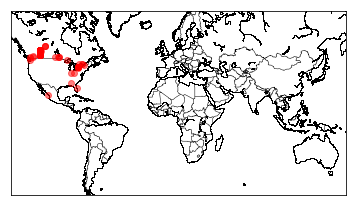

In [16]:
# plot the blank world map
my_map = Basemap(projection='merc', lat_0=50, lon_0=-100,
                     resolution = 'h', area_thresh = 5000.0,
                     llcrnrlon=-140, llcrnrlat=-55,
                     urcrnrlon=160, urcrnrlat=70)
# set resolution='h' for high quality
 
# draw elements onto the world map
my_map.drawcountries()
#my_map.drawstates()
my_map.drawcoastlines(antialiased=False, linewidth=0.005)
 
# add coordinates as red dots
longs = list(greycup_tweets.loc[(greycup_tweets.long != None)].long)
latts = list(greycup_tweets.loc[greycup_tweets.latt != None].latt)
x, y = my_map(longs, latts)
my_map.plot(x, y, 'ro', markersize=6, alpha=0.5)
 
plt.show()

In [17]:
# Copy over greycup_tweets to new dataframe 'tweets' for simplicity
tweets = greycup_tweets

In [18]:
type(tweets)

pandas.core.frame.DataFrame

In [19]:
tweets.tail(n=10)

,text,location,lang,country_code,long,latt
50046,RT @calstampeders: 2018 GREY CUP CHAMPIONS!!!🎉...,Calgary,en,None,NaN,NaN
50047,RT @calstampeders: 2018 GREY CUP CHAMPIONS!!!🎉...,"Canada, eh? 🇨🇦",en,None,NaN,NaN
50048,GREY CUP CHAMPS! ❤️🏈🖤 Congrats @sbergman67 @al...,Alberta,en,None,NaN,NaN
50049,RT @CdnPress_Sports: CP NewsAlert: Stampeders ...,"ÜT: 45.4610596,-73.7301865",en,None,NaN,NaN
50050,"WOO 2018 grey cup champions, go stamps go",calgary,en,None,NaN,NaN
50051,RT @Sid_Seixeiro: It’s nice to see the Grey Cu...,,en,None,NaN,NaN
50052,RT @WineMummy: *takes drag of cigarette*\n\nSo...,"Nebraska, USA",en,None,NaN,NaN
50053,RT @calstampeders: 2018 GREY CUP CHAMPIONS!!!🎉...,"Calgary, Canada",en,None,NaN,NaN
50054,RT @calstampeders: 2018 GREY CUP CHAMPIONS!!!🎉...,pinapple under the sea,en,None,NaN,NaN
50055,Congratulations to the @calstampeders on one h...,"Surrey, BC",en,None,NaN,NaN


In [20]:
import re

In [21]:
# Count top languages in which tweets were written
tweets_by_lang = tweets['lang'].value_counts()
tweets_by_lang[:3]

en     48656
und      858
fr       185
Name: lang, dtype: int64

In [22]:
import matplotlib.pyplot as plt

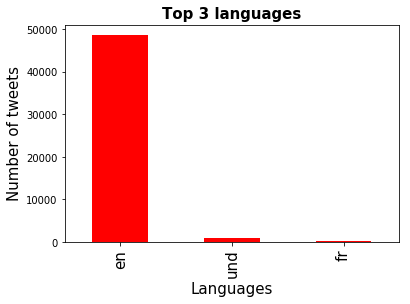

In [23]:
# Plot graphically top languages in which the tweets were written
tweets_by_lang = tweets['lang'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Languages', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 3 languages', fontsize=15, fontweight='bold')
tweets_by_lang[:3].plot(ax=ax, kind='bar', color='red')

In [24]:
# Count top 3 user location from which tweets were sent
tweets_by_location = tweets['location'].value_counts()
tweets_by_location[2:5]

Calgary, Alberta     2212
Edmonton, Alberta    1683
Toronto, Ontario      994
Name: location, dtype: int64

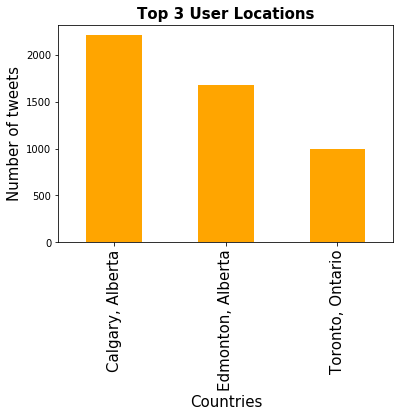

In [25]:
# Plot top user locations from which the tweets were sent
tweets_by_location = tweets['location'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Countries', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 3 User Locations', fontsize=15, fontweight='bold')
tweets_by_location[2:5].plot(ax=ax, kind='bar', color='orange')

In [26]:
# Count top 2 countries from which tweets were sent
tweets_by_country = tweets['country_code'].value_counts()
tweets_by_country[0:2]

CA    2015
US     318
Name: country_code, dtype: int64

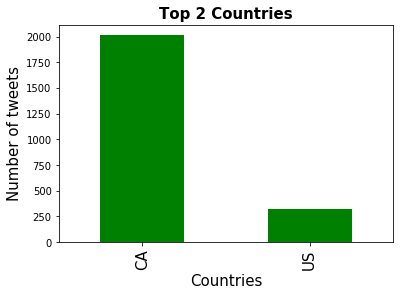

In [27]:
# Plot top countries from which the tweets were sent
tweets_by_country = tweets['country_code'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Countries', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 2 Countries', fontsize=15, fontweight='bold')
tweets_by_country[0:2].plot(ax=ax, kind='bar', color='green')

In [28]:
# Create function to return boolean result if a word is found in the text
def word_in_text(word, text):
    word = word.lower()
    text = text.lower()
    match = re.search(word, text)
    if match:
        return True
    return False

In [29]:
tweets.head()

,text,location,lang,country_code,long,latt
0,When your dad scores @cfl team beer cozies and...,Canada,en,None,NaN,NaN
1,RT @calstampeders: Join us tonight at the Scot...,"Calgary, Alberta",en,None,NaN,NaN
2,RT @Avry: NEW: Here's the full audio version o...,"Florence, AL",en,None,NaN,NaN
3,RT @CFL: The incredible @alessiacara performan...,,en,None,NaN,NaN
4,RT @GreyCupFestival: When 🏈+🏒collide! Thanks f...,Regina,en,None,NaN,NaN


In [30]:
# Add additional columns to the 'tweets' data frame:

# Begin sorting results by relevancy
# This list CAN vary depending on the search 'texts'
tweets['#GreyCup'] = tweets['text'].apply(lambda tweet: word_in_text('#GreyCup', tweet))
tweets['Grey Cup'] = tweets['text'].apply(lambda tweet: word_in_text('Grey Cup', tweet))


In [31]:
tweets.head(n=10)

,text,location,lang,country_code,long,latt,#GreyCup,Grey Cup
0,When your dad scores @cfl team beer cozies and...,Canada,en,None,NaN,NaN,False,False
1,RT @calstampeders: Join us tonight at the Scot...,"Calgary, Alberta",en,None,NaN,NaN,True,False
2,RT @Avry: NEW: Here's the full audio version o...,"Florence, AL",en,None,NaN,NaN,False,False
3,RT @CFL: The incredible @alessiacara performan...,,en,None,NaN,NaN,True,False
4,RT @GreyCupFestival: When 🏈+🏒collide! Thanks f...,Regina,en,None,NaN,NaN,True,False
5,RT @EdmontonEsks: Thank you Edmonton. Thank yo...,,en,None,NaN,NaN,True,False
6,"RT @calstampeders: The #GreyCup, a @NHLFlames ...",,en,None,NaN,NaN,True,False
7,RT @CFL: The incredible @alessiacara performan...,"Vancouver, Canada",en,None,NaN,NaN,True,False
8,RT @NHLFlames: The #Flames were pumped to see ...,,en,None,NaN,NaN,True,False
9,NEW: Here's the full audio version of Episode ...,Edmonton/Toronto,en,None,NaN,NaN,False,False


In [32]:
# Counts for each reference of the given topic
print (tweets['#GreyCup'].value_counts()[True])
print (tweets['Grey Cup'].value_counts()[True])


33700
10768


In [33]:
# Common words before ANY text cleaning
# Top 5
freq = pd.Series(' '.join(tweets['text']).split()).value_counts()[:5]
freq

the         36459
RT          31133
#GreyCup    25620
to          16261
in          11857
dtype: int64

In [34]:
# Only extract relevant tweets containing useful keywords

# tweets.drop(['Unnamed: 5', 'Unnamed: 6', 'sepal length.1', 'Unnamed: 8'],axis=1,inplace=True)
tweets['Relevant'] = tweets['text'].apply(lambda tweet: word_in_text('#GreyCup', tweet) or word_in_text('Grey Cup', tweet))

# Print count for of relevant tweets
print ('Relevant Tweets: ' + str(tweets['Relevant'].value_counts()[True]))

Relevant Tweets: 43182


In [35]:
tweets.head(n=6)

,text,location,lang,country_code,long,latt,#GreyCup,Grey Cup,Relevant
0,When your dad scores @cfl team beer cozies and...,Canada,en,None,NaN,NaN,False,False,False
1,RT @calstampeders: Join us tonight at the Scot...,"Calgary, Alberta",en,None,NaN,NaN,True,False,True
2,RT @Avry: NEW: Here's the full audio version o...,"Florence, AL",en,None,NaN,NaN,False,False,False
3,RT @CFL: The incredible @alessiacara performan...,,en,None,NaN,NaN,True,False,True
4,RT @GreyCupFestival: When 🏈+🏒collide! Thanks f...,Regina,en,None,NaN,NaN,True,False,True
5,RT @EdmontonEsks: Thank you Edmonton. Thank yo...,,en,None,NaN,NaN,True,False,True


In [36]:
# Use function if required to clean text
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [37]:
# Function to remove hashtags, URLs, mentions, punctuations, RTs, whitespace 
def clean_tweet(tweet):
    
    #tweet = re.sub('http\S+\s*', '', tweet)  # remove URLs
    #tweet = re.sub('RT|cc', '', tweet)       # remove RT and cc
    #tweet = re.sub('RT', '', tweet)          # remove RT only
    #tweet = re.sub('#\S+', '', tweet)        # remove hashtags
    #tweet = re.sub('@\S+', '', tweet)        # remove mentions    
    #tweet = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', tweet) # remove punctuations     
    #tweet = re.sub('\s+', ' ', tweet)        # remove extra whitespace
    #tweet = remove_emoji(tweet)              # remove any emoticons/images/symbols/flags/pics
    
    # [Do not REMOVE numbers - will need all references to 2018 in text]
    #tweet = re.sub('[0-9_]', '', tweet)      # remove numbers 
    
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(RT|cc)", " ", tweet).split()) 
    return tweet

In [38]:
# hold length of tweets dataframe
length = len(tweets)
length

50056

In [39]:
# loop through every 'text' record and clean tweets

i=0

for tweet in tweets['text']:
    tweet = clean_tweet(tweet).lower()
    tweets.loc[i,'text'] = tweet
    if(i==length):
        break
    else:
        i = i+1


In [40]:
tweets.head(n=10)

,text,location,lang,country_code,long,latt,#GreyCup,Grey Cup,Relevant
0,when your dad scores team beer cozies and turn...,Canada,en,None,NaN,NaN,False,False,False
1,join us tonight at the scotiabank saddledome a...,"Calgary, Alberta",en,None,NaN,NaN,True,False,True
2,new here s the full audio version of episode 3...,"Florence, AL",en,None,NaN,NaN,False,False,False
3,the incredible performance at the greycup half...,,en,None,NaN,NaN,True,False,True
4,when collide thanks for offering our greycup o...,Regina,en,None,NaN,NaN,True,False,True
5,thank you edmonton thank you cfl fans you help...,,en,None,NaN,NaN,True,False,True
6,the greycup a jersey and championship belt cou...,,en,None,NaN,NaN,True,False,True
7,the incredible performance at the greycup half...,"Vancouver, Canada",en,None,NaN,NaN,True,False,True
8,the flames were pumped to see the win the grey...,,en,None,NaN,NaN,True,False,True
9,new here s the full audio version of episode 3...,Edmonton/Toronto,en,None,NaN,NaN,False,False,False


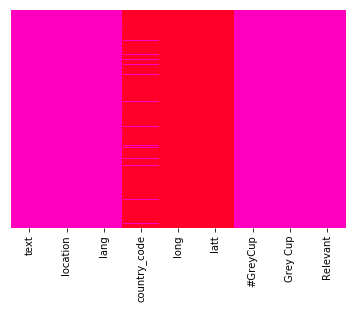

In [41]:
# Generate heat map of tweets dataframe for any column(s) with NaNs/None/Nulls
import seaborn as sns
sns.heatmap(tweets.isnull(),yticklabels=False,cbar=False,cmap='gist_rainbow_r')

In [42]:
# Total # of NaNs/NULL value for each Columns/Records in data frame

null_columns=tweets.columns[tweets.isnull().any()]
tweets[null_columns].isnull().sum() 

country_code    47689
long            49887
latt            49887
dtype: int64

In [43]:
# Drop column(s) if majori-ty are None/Null/NaNs
# NOT Required anymore
tweets.drop(['country_code','long','latt'], axis = 1, inplace = True)


In [44]:
tweets.head(n=6)

,text,location,lang,#GreyCup,Grey Cup,Relevant
0,when your dad scores team beer cozies and turn...,Canada,en,False,False,False
1,join us tonight at the scotiabank saddledome a...,"Calgary, Alberta",en,True,False,True
2,new here s the full audio version of episode 3...,"Florence, AL",en,False,False,False
3,the incredible performance at the greycup half...,,en,True,False,True
4,when collide thanks for offering our greycup o...,Regina,en,True,False,True
5,thank you edmonton thank you cfl fans you help...,,en,True,False,True


In [45]:
# Common words AFTER cleaning text (No STOPWORDS removed)
# Top 5
freq = pd.Series(' '.join(tweets['text']).split()).value_counts()[:5]
freq

the        44357
greycup    33631
to         16805
a          12780
in         12765
dtype: int64

In [46]:
# AFter tweets have been cleaned of hashtags, URLs, mentions, punctuations, RTs, whitespace.
# Perform sentiment analysis

def get_tweet_sentiment(tweet): 

    #Utility function to classify sentiment of passed tweet 
    #using textblob's sentiment method 

    # create TextBlob object of passed tweet text 
    analysis = TextBlob(clean_tweet(tweet)) 
    # set sentiment 
    if analysis.sentiment.polarity > 0: 
        return 4  #positive
    elif analysis.sentiment.polarity == 0: 
        return 2  #neutral
    else: 
        return 0  #negative

In [47]:
# Add new column 'sentiment' --> Class attribute for sentiment analysis
tweets['sentiment'] = tweets['text'].apply(lambda tweet: get_tweet_sentiment(tweet))

In [48]:
tweets.head()

,text,location,lang,#GreyCup,Grey Cup,Relevant,sentiment
0,when your dad scores team beer cozies and turn...,Canada,en,False,False,False,2
1,join us tonight at the scotiabank saddledome a...,"Calgary, Alberta",en,True,False,True,2
2,new here s the full audio version of episode 3...,"Florence, AL",en,False,False,False,4
3,the incredible performance at the greycup half...,,en,True,False,True,4
4,when collide thanks for offering our greycup o...,Regina,en,True,False,True,4


In [49]:
print("\n")
# percentage of positive tweets 
ptweets = [tweet for tweet in tweets['sentiment'] if tweet == 4] 
print("Positive tweets percentage: {} %".format(100*len(ptweets)/len(tweets))) 

# percentage of negative tweets 
ntweets = [tweet for tweet in tweets['sentiment'] if tweet == 0] 
print("Negative tweets percentage: {} %".format(100*len(ntweets)/len(tweets))) 

# percentage of neutral tweets 
neutweets = [tweet for tweet in tweets['sentiment'] if tweet == 2] 
print("Neutral tweets percentage: {} %".format(100*len(neutweets)/len(tweets))) 

print("\n")



Positive tweets percentage: 42.58031005274093 %
Negative tweets percentage: 22.750519418251557 %
Neutral tweets percentage: 34.66917052900751 %




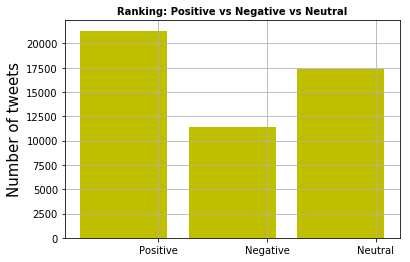

In [50]:
# Plot distribution of sentiments of the analysed tweets

prg_langs = ['Positive', 'Negative', 'Neutral']
tweets_by_prg_lang = [len(ptweets), len(ntweets), len(neutweets)]

x_pos = list(range(3))
width = 0.8
fig, ax = plt.subplots()
plt.bar(x_pos, tweets_by_prg_lang, width, alpha=1, color='y')

# Setting axis labels and ticks
ax.set_ylabel('Number of tweets', fontsize=15)
ax.set_title('Ranking: Positive vs Negative vs Neutral', fontsize=10, fontweight='bold')
ax.set_xticks([p + 0.4 * width for p in x_pos])
ax.set_xticklabels(prg_langs)
plt.grid()

In [51]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

# Download these packages if required
#nltk.download('punkt')
#nltk.download('stopwords')

In [ ]:
stop = stopwords.words('english')
stop

In [53]:
from nltk.stem import PorterStemmer, LancasterStemmer
# lst=LancasterStemmer() # more aggressive - so avoid using this stemming technique

In [54]:
def stem_words(words):
    stemmer = PorterStemmer() #not as aggressive
    stems=[]
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

In [55]:
# Remove stopwords and stem results
i=0
tokenized_tweet = []

for tweet in tweets['text']:
    tokenized = word_tokenize(tweet)
    stems = stem_words(tokenized)
    tweets.loc[i,'text'] = " ".join(list(x for x in stems if x not in stop))
    if(i==length):
        break
    else:
        i=i+1

In [56]:
# Common words AFTER ALL text cleaning is complete (Stemmed text)
# Top 5
freq = pd.Series(' '.join(tweets['text']).split()).value_counts()[:4]
freq = freq.to_frame()
freq.columns = ['count']
freq

,count
greycup,33633
grey,11642
cup,11615
cfl,5330


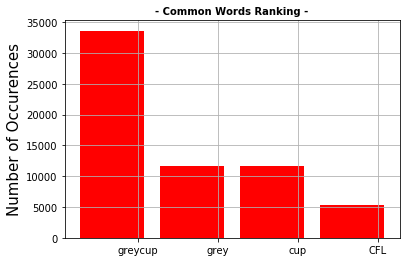

In [57]:
prg_langs = ['greycup', 'grey', 'cup', 'CFL']
tweets_by_prg_lang = [freq['count'][0],freq['count'][1], freq['count'][2], freq['count'][3]]

x_pos = list(range(4))
width = 0.8
fig, ax = plt.subplots()
plt.bar(x_pos, tweets_by_prg_lang, width, alpha=1, color='r')

# Setting axis labels and ticks
ax.set_ylabel('Number of Occurences', fontsize=15)
ax.set_title('- Common Words Ranking -', fontsize=10, fontweight='bold')
ax.set_xticks([p + 0.4 * width for p in x_pos])
ax.set_xticklabels(prg_langs)
plt.grid()

In [58]:
# pip install wordcloud - python terminal windoe
from wordcloud import WordCloud

In [59]:
def wordcloud(tweets,col):
    #stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color="white",stopwords=stop,random_state = 2016).generate(" ".join([i for i in tweets[col]]))
    plt.figure( figsize=(15,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Good Morning Datascience+")

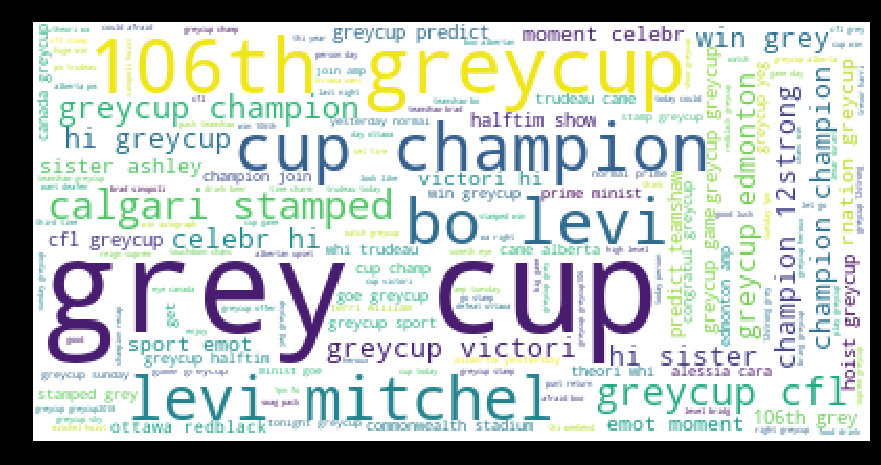

In [60]:
# WordCloud of most commonly occuring words
wordcloud(tweets,'text')

In [61]:
tweets.head()

,text,location,lang,#GreyCup,Grey Cup,Relevant,sentiment
0,dad score team beer cozi turn shirt stuffi cfl...,Canada,en,False,False,False,2
1,join us tonight scotiabank saddledom greycup c...,"Calgary, Alberta",en,True,False,True,2
2,new full audio version episod 30 hour guest st...,"Florence, AL",en,False,False,False,4
3,incred perform greycup halftim show glori,,en,True,False,True,4
4,collid thank offer greycup towner sneak peek,Regina,en,True,False,True,4


In [62]:
len(tweets)

50056

In [63]:
# Split up the data into a training and test set
from sklearn.model_selection import train_test_split

In [64]:
# Class attributes for sentiment analysis
# Display last 12
tweets['sentiment'].head(n=12)

0     2
1     2
2     4
3     4
4     4
5     2
6     4
7     4
8     4
9     4
10    2
11    4
Name: sentiment, dtype: int64

In [65]:
tweets['text'].head()

0    dad score team beer cozi turn shirt stuffi cfl...
1    join us tonight scotiabank saddledom greycup c...
2    new full audio version episod 30 hour guest st...
3            incred perform greycup halftim show glori
4         collid thank offer greycup towner sneak peek
Name: text, dtype: object

In [66]:
# Seperate train and test dataset (sentiment - class attribute)
X = tweets.drop('sentiment', axis = 1)
y = tweets['sentiment']

In [67]:
# Split dataset 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 5) # 80% - 20% split

In [68]:
X_train.head()

,text,location,lang,#GreyCup,Grey Cup,Relevant
38009,offens lineman check day 1 practic greycup,,en,True,False,True
2481,calgari win mean greycup longer haunt bo levi ...,"Burlington, Ontario",en,True,False,True
45302,felt like mounti bring grey cup left canada to...,Edmonton,en,False,True,True
35109,seen far greycup week marsh break htt,"Halifax, Nova Scotia",en,True,False,True
9842,red redempt greycup stamp,"Winnipeg, Manitoba",en,True,False,True


In [69]:
# Type = Series
y_train.head()

38009    2
2481     4
45302    4
35109    0
9842     2
Name: sentiment, dtype: int64

In [70]:
X_train = list(X_train['text'])

In [71]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(stop_words = 'english')

In [72]:
text = vec.fit_transform(X_train)

In [ ]:
print(vec.vocabulary_)

In [76]:
text.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [77]:
X_test.head()

,text,location,lang,#GreyCup,Grey Cup,Relevant
991,nation stage region campus loggersport team br...,"Pembroke, ON",en,False,False,False
28771,predict teamshaw bo levi mitchel hoist greycup...,Calgary AB,en,True,False,True
6418,landmark high level bridg stay lit tonight col...,"Edmonton, Alberta",en,True,False,True
30932,excit greycup weekend team includ heroux mani ...,,en,True,False,True
45424,team stori fight injuri lost past two grey cup...,,en,False,True,True


In [78]:
y_test.head()

991      2
28771    2
6418     4
30932    4
45424    4
Name: sentiment, dtype: int64

In [79]:
X_test = list(X_test['text'])

In [80]:
type(X_test)

list

In [81]:
vec.transform(X_test).toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [82]:
import pandas as pd

In [83]:
# Create dataframe for train dataset (X_test, y_test)
df = pd.DataFrame(vec.fit_transform(X_train).toarray(), columns=vec.get_feature_names())
df

,00,000,00e,00pm,01,013,02,039,04,04m,...,ziplin,zipper,zit,zmorn,zoesshoesdowntown,zone,zonker,zoom,zzz,zzzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
# Create dataframe for Test data set (X_test, y_test)
test_df = pd.DataFrame(vec.transform(X_test).toarray(), columns = vec.get_feature_names())
test_df

,00,000,00e,00pm,01,013,02,039,04,04m,...,ziplin,zipper,zit,zmorn,zoesshoesdowntown,zone,zonker,zoom,zzz,zzzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
df_train = y_train.to_frame()
df_train.columns = ['class']

df_test = y_test.to_frame()
df_test.columns = ['class']

In [86]:
x_train = df
y_train = df_train['class']

x_test = test_df
y_test = df_test['class']

In [87]:
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB 
from sklearn.naive_bayes import MultinomialNB

In [88]:
# MODEL 1:
# Build Naive_Bayes supervised learning model and compute accuracy against test dataset

algorithm_a = MultinomialNB()

In [89]:
# fit model with train dataset
algorithm_a.fit(x_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [90]:
output = algorithm_a.predict(x_test)

In [91]:
# Test model accuracy with Test dataset (class, output)
metrics.accuracy_score(y_test, output)

0.8662604874151019

In [92]:
# Model predicted confusion matrix 
metrics.confusion_matrix(y_test,output)

array([[1791,   82,  365],
       [ 123, 2937,  395],
       [ 171,  203, 3945]], dtype=int64)

In [82]:
# MODEL 2:
# Build support vector machines (SVM) learning model

In [94]:
tweets.head()

,text,location,lang,#GreyCup,Grey Cup,Relevant,sentiment
0,dad score team beer cozi turn shirt stuffi cfl...,Canada,en,False,False,False,2
1,join us tonight scotiabank saddledom greycup c...,"Calgary, Alberta",en,True,False,True,2
2,new full audio version episod 30 hour guest st...,"Florence, AL",en,False,False,False,4
3,incred perform greycup halftim show glori,,en,True,False,True,4
4,collid thank offer greycup towner sneak peek,Regina,en,True,False,True,4


In [95]:
#LINEAR KERNEL (SVM) Learning Model

import sklearn.svm as svm
clf = svm.SVC(kernel='linear')

In [ ]:
# Train classifier 
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test) 

In [ ]:
# Performs slightly better that Naive_Bayes

from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred)) 

In [ ]:
# MODEL 3:

In [ ]:
# Polynomial Kernel (SVM)
from sklearn.svm import SVC  
svclassifier = SVC(kernel='poly', degree=8)  
svclassifier.fit(x_train, y_train) 

In [ ]:
y_pred = svclassifier.predict(x_test)  

In [ ]:
#Compare confusion matrix results:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred)) 
